# Sparse Linear Inverse with EM Learning

In the [sparse linear inverse demo](./sparse_lin_inverse.ipynb), we saw how to set up a solve a simple sparse linear inverse problem using the `vamp` method in the `vampyre` package.  Specifically, we solved for a vector $x$ from linear measurements of the form $y=Ax+w$.  Critical in demo was that the `vamp` method had to be supplied a description of the statistics on the components on $x$ and the noise variance $w$.  In many practical cases though, these are not known.  In the demo, we show how to simultaneously learn $x$ and the distribution on $x$ with EM learning.

The example here is taken from the following paper which introduced the combination of VAMP with EM learning:
> Fletcher, Alyson K., and Philip Schniter. [Learning and free energies for vector approximate message passing,](http://ieeexplore.ieee.org/abstract/document/7952957/) Proc. IEEE Acoustics, Speech and Signal Processing (ICASSP), 2017.

## Importing the Package 


First, as in the [sparse linear inverse demo](./sparse_lin_inverse.ipynb) we load `vampyre` and other packages.

In [15]:
# Import vampyre
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

# Import the other packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generating Synthetic Data

Next, we will generate the synthetic sparse data.  Recall, that in the sparse linear inverse problem, we want to estimate a vector $z_0$ from measurements
$$
    y = Az_0 + w,
$$
for some known linear transform $A$.  The vector $w$ represents noise.

The sparse vector $z_0$ is described probabilistically.  We will use a slightly different model than in the sparse linear inverse demo, and describe the sparse vector $z_0$ as a [Gaussian mixture model](https://en.wikipedia.org/wiki/Mixture_model): Each component of the vector $z_0$ is distributed as being randomly one of two components:
$$
    z_{0j} \sim \begin{cases} 
        N(0,\sigma^2_H) & \mbox{with prob } P_H, \\
        N(0,\sigma^2_L) & \mbox{with prob } P_L, 
    \end{cases}
$$
where $\sigma^2_H$ represents a *high* variance and $\sigma^2_L$ a *low* variance.  Thus, with some probability $p_L$, the component is small (close to zero) and probability $p_H$ it is large.  

In [16]:
# Dimensions
nz0 = 1000
nz1 = 500
ncol = 10
zshape0 = (nz0,ncol)
zshape1 = (nz1,ncol)

# Parameters for the two components
varc_lo = 1e-4       # variance of the low variance component
varc_hi = 1          # variance of the high variance component
prob_hi = 0.1        # probability of the high variance component
prob_lo = 1-prob_hi
meanc = np.array([0,0])
probc = np.array([prob_lo, prob_hi])    
varc = np.array([varc_lo, varc_hi])
nc = len(probc)    

# Generate random data following the GMM model
zlen = np.prod(zshape0)
ind = np.random.choice(nc,zlen,p=probc)
u = np.random.randn(zlen)
z0 = u*np.sqrt(varc[ind]) + meanc[ind]
z0 = z0.reshape(zshape0)
    

Next, we generate a random matrix.  Before, we generated the random matrix with Gaussian iid entries.  In this example, to make the problem more challenging, we will use a more ill-conditioned random matrix.  The method `rand_rot_invariant` creates a random matrix with a specific condition number.

In [17]:
cond_num = 100    # Condition number
A = vp.trans.rand_rot_invariant_mat(nz1,nz0,cond_num=cond_num)
z1 = A.dot(z0)

Finally, we add noise at the desired SNR

In [18]:
snr = 40    # SNR in dB
yvar = np.mean(np.abs(z1)**2)
wvar = yvar*np.power(10, -0.1*snr)
y = z1 + np.random.normal(0,np.sqrt(wvar), zshape1)

## Set up the solvers 

As in the sparse inverse demo, the VAMP estimator requires that we specify two probability distributions:
* Prior:  $p(z_0|\theta_0)$;
* Likelihood:  $p(y|z_0,\theta_1)$.
In this case, both densities depend on *parameters*: $\theta_0$ and $\theta_1$.  For the prior, the parameters $\theta_0$ represent the parameters of the components `(probc,meanc,varc)`.  For the likelihood, the unknown parameter $\theta_1$ is the output variance `wvar`.

EM estimation is a method that allows to learn the values of the parameters $\theta_0$ and $\theta_1$ while also estimating the vector $z_0$.

EM estimation is an iterative technique and requires that we specify initial estimates for the unknown parameters: `wvar,probc,meanc,varc`.  We will use the initialization in the paper above.

In [29]:
# Initial estimate for the noise
wvar_init = np.mean(np.abs(y)**2)

# Intiial estimates for the component means, variances and probabilities
meanc_init = np.array([0,0])
prob_hi_init = np.minimum(nz1/nz0/2,0.95)
prob_lo_init = 1-prob_hi_init
var_hi_init = yvar/np.mean(np.abs(A)**2)/nz0/prob1
var_lo_init = 1e-4   
probc_init = np.array([prob_lo_init, prob_hi_init])
varc_init = np.array([var_lo_init, var_hi_init])

To evaluate the EM method, we will compare it against an *oracle* that knows the true density.  We thus create two estimators for the prior:  one for the oracle that is set to the true GMM parameters with tuning disabled (`tune_gmm=False`); and one for the EM estimator where the parameters are set to the initial estimators and tuning enabled (`tune_gmm=True`).

In [30]:
# Estimator with EM, initialized to the above values
est_in_em = vp.estim.GMMEst(shape=zshape0,\
    zvarmin=1e-6,tune_gmm=True,probc=probc_init,meanc=meanc_init, varc=varc_init)

# No auto-tuning.  Set estimators with the true values
est_in_oracle = vp.estim.GMMEst(shape=zshape0, probc=probc, meanc=meanc, varc=varc, tune_gmm=False)

We also create two estimators for the likelihood $p(y|z1,wvar)$.  For the oracle estimator, the parameter `wvar` is set to its true value; for the EM estimator it is set to its initial estimate `wvar_init`.

In [31]:
Aop = vp.trans.MatrixLT(A,zshape0)
b = np.zeros(zshape1)
map_est = False
est_out_em     = vp.estim.LinEstim(Aop,y,wvar=wvar_init,map_est=map_est,tune_wvar=True)
est_out_oracle = vp.estim.LinEstim(Aop,y,wvar=wvar,map_est=map_est,tune_wvar=False)

## Running the solvers for the oracle and EM case

We first run the solver for the oracle case and measure the MSE per iteration.

In [32]:
# Create the message handler
msg_hdl = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape0)

# Create the solver
nit = 40
solver = vp.solver.Vamp(est_in_oracle, est_out_oracle,msg_hdl,hist_list=['zhat'],nit=nit) 

# Run the solver
solver.solve()

# Get the estimation history
zhat_hist = solver.hist_dict['zhat']
nit2 = len(zhat_hist)
zpow = np.mean(np.abs(z0)**2)

mse_oracle = np.zeros(nit2)
for it in range(nit2):
    zhati = zhat_hist[it]
    zerr = np.mean(np.abs(zhati-z0)**2)
    mse_oracle[it] = 10*np.log10(zerr/zpow)
    
# Print final MSE
print("Final MSE (oracle) = {0:f} dB".format(mse_oracle[-1]))

Final MSE (oracle) = -28.398708 dB


Next, we run the EM estimator.  We see we obtain a similar final MSE.

In [33]:
# Create the message handler
msg_hdl = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape0)

# Create the solver
solver = vp.solver.Vamp(est_in_em, est_out_em, msg_hdl,hist_list=['zhat'],nit=nit)       

# Run the solver
solver.solve()

# Get the estimation history
zhat_hist = solver.hist_dict['zhat']
nit2 = len(zhat_hist)
zpow = np.mean(np.abs(z0)**2)

mse_em = np.zeros(nit2)
for it in range(nit2):
    zhati = zhat_hist[it]
    zerr = np.mean(np.abs(zhati-z0)**2)
    mse_em[it] = 10*np.log10(zerr/zpow)
    
# Print final MSE
print("Final MSE (EM) = {0:f} dB".format(mse_em[-1]))    

Final MSE (EM) = -28.371821 dB


We plot the two MSEs as a function of the iteration number.

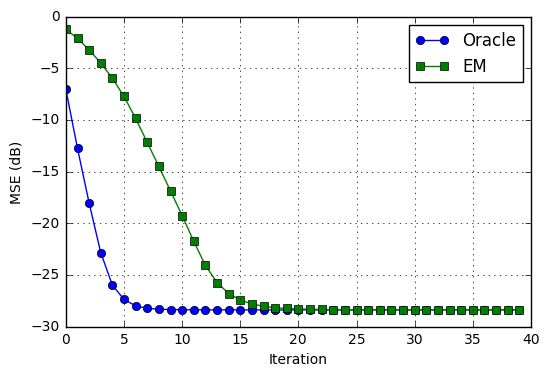

In [35]:
t = np.arange(nit2)
plt.plot(t,mse_oracle,'o-')
plt.plot(t,mse_em,'s-')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('MSE (dB)')
plt.legend(['Oracle', 'EM'])
plt.show()


We see that the EM algorithm is eventually able to obtain the same MSE, but with a few more iterations.